# Suggest-Evaluate-Register Paradigm with Bayesian Optimization
This is adapted to mannual experiment evaluation process, without a close-form black box function (the experiment is the black box).

Follow the process to find the next parameter for experiment
### Adjustment can be updated:
- Initial data fitting: Gaussian Process Model
- Utility function: ubs, ei, poi
- Based on a two input setup --> for more than two parameters, plot seperate plots to visualize the relationship 

## Step 0: Initial setup

<font color='red'> # Updates 04.20
- In this version, I delete raw dat part time outside range (1, 5) and normalize all data based on 1-5 range
- I used the inital 7 data, 1st round 5 data (square burn-in), 3rd round 5 data (circular burn in) = 17 data </font>

In [1]:
# ! pip install bayesian-optimization

In [1]:
from bayes_opt import BayesianOptimization
import numpy as np
import matplotlib.pyplot as plt

import ipywidgets as widgets
from IPython.display import display

import pandas as pd

In [2]:
import logging
# Configure logging
logging.basicConfig(filename='bayesian_optimization.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')
# # Function to log a message
# def log_experiment(params, result):
#     logging.info(f"Experiment with params {params} yielded result {result}")

def log_experiment(params, result=None):
    if result is not None:
        logging.info(f"Experiment conducted with params {params} yielded result {result}")
    else:
        logging.info(f"Suggestion made with params {params} without result yet")

## Step 0-1: Process and Store data

Functions requried

In [3]:
# Evaluation score based on an objective function combine the accuracy (above or below the norminal) and success rate (percentage printed on build plate)
def calculate_accuracy_score(accuracy_percentage):
    #accuracy_percentage = (measured_size / nominal_size) * 100
    score = max(0, 1 - abs((accuracy_percentage - 100) / 100))
    return score

# # Example usage
# nominal_size = 10.0  # Nominal size in units
# measured_size = 11.5  # Measured size in units
# score = calculate_accuracy_score(measured_size, nominal_size)
# print(f"Accuracy Score: {score:.2f}")
# accuracy_percentage = 117
# score = calculate_accuracy_score(accuracy_percentage)
# print(f"Accuracy Score: {score:.2f}")

In [4]:
# Functions for normalizing the parameters for effectively explore the searching space
def normalize(value, min_bound, max_bound):
    return (value - min_bound) / (max_bound - min_bound)

#def normalize_parameters(params, bounds):
    normalized_params = {}
    for key in params:
        normalized_params['normalized_' + key] = normalize(params[key], bounds[key][0], bounds[key][1])
    return normalized_params

def denormalize(normalized_value, min_bound, max_bound):
    return normalized_value * (max_bound - min_bound) + min_bound

In [5]:
#def overall_objective(measured_size, nominal_size, success_percentage):
def overall_objective(accuracy_percentage, success_percentage):    
    """
    Calculates the overall objective score combining accuracy and success.
    
    Args:
    measured_size (float): The actual size measured from the printed part.
    nominal_size (float): The intended nominal size of the printed part.
    success_percentage (float): Continuous measure from 0 to 1 of successful printing completion.

    Returns:
    float: Combined objective score, where higher is better.
    """
    # Calculate the accuracy score based on deviation from nominal size
    #accuracy_score = calculate_accuracy_score(accuracy_percentage)
    accuracy_score = np.maximum(0, 1 - abs((accuracy_percentage - 100) / 100))
    # Success percentage is already normalized between 0 and 1
    success_score = success_percentage

    # Weighted sum of accuracy and success
    overall_score = 0.5 * accuracy_score + 0.5 * success_score
    
    return overall_score

In [6]:
overall_objective(100, 0)

0.5

Create dataframe and log data

In [8]:
# Log previous data
import pandas as pd

# Load the data"
df = pd.read_csv('Exp_log_fulldata.csv')
df

,Unnamed: 0,base_t,part_t,layer_th,accuracy,success_r,base_t_min,base_t_max,part_t_min,part_t_max,layer_t_min,layer_t_max
0,1,10.000,2.000,0.50,95.0,0.30,5,15,1,5,0.1,0.5
1,2,10.000,5.000,0.50,95.0,0.00,5,15,1,5,0.1,0.5
2,3,5.000,5.000,0.50,95.0,0.00,5,15,1,5,0.1,0.5
3,4,5.000,2.000,0.50,95.0,0.00,5,15,1,5,0.1,0.5
4,5,14.000,4.000,0.50,95.0,0.00,5,15,1,5,0.1,0.5
5,6,10.000,2.000,0.20,95.0,0.00,5,15,1,5,0.1,0.5
6,7,10.000,1.500,0.20,95.0,0.00,5,15,1,5,0.1,0.5
7,8,9.957,2.159,0.18,100.0,0.50,5,15,1,5,0.1,0.5
8,9,7.661,4.362,0.17,124.0,-1.00,5,15,1,5,0.1,0.5
9,10,9.842,2.115,0.15,107.5,-1.00,5,15,1,5,0.1,0.5


In [9]:
df['base_t_n'] = normalize (df['base_t'], df['base_t_min'], df['base_t_max'])
df['part_t_n'] = normalize (df['part_t'], df['part_t_min'], df['part_t_max'])
df['layer_th_n'] = normalize (df['layer_th'], df['layer_t_min'], df['layer_t_max'])
df['overall_objective'] = overall_objective(df['accuracy'], df['success_r'])

In [10]:
df.head()
df.to_csv('calculated_17data_0430_1.csv', index=False)

In [11]:
df

,Unnamed: 0,base_t,part_t,layer_th,accuracy,success_r,base_t_min,base_t_max,part_t_min,part_t_max,layer_t_min,layer_t_max,base_t_n,part_t_n,layer_th_n,overall_objective
0,1,10.000,2.000,0.50,95.0,0.30,5,15,1,5,0.1,0.5,0.5000,0.25000,1.000,0.6250
1,2,10.000,5.000,0.50,95.0,0.00,5,15,1,5,0.1,0.5,0.5000,1.00000,1.000,0.4750
2,3,5.000,5.000,0.50,95.0,0.00,5,15,1,5,0.1,0.5,0.0000,1.00000,1.000,0.4750
3,4,5.000,2.000,0.50,95.0,0.00,5,15,1,5,0.1,0.5,0.0000,0.25000,1.000,0.4750
4,5,14.000,4.000,0.50,95.0,0.00,5,15,1,5,0.1,0.5,0.9000,0.75000,1.000,0.4750
5,6,10.000,2.000,0.20,95.0,0.00,5,15,1,5,0.1,0.5,0.5000,0.25000,0.250,0.4750
6,7,10.000,1.500,0.20,95.0,0.00,5,15,1,5,0.1,0.5,0.5000,0.12500,0.250,0.4750
7,8,9.957,2.159,0.18,100.0,0.50,5,15,1,5,0.1,0.5,0.4957,0.28975,0.200,0.7500
8,9,7.661,4.362,0.17,124.0,-1.00,5,15,1,5,0.1,0.5,0.2661,0.84050,0.175,-0.1200
9,10,9.842,2.115,0.15,107.5,-1.00,5,15,1,5,0.1,0.5,0.4842,0.27875,0.125,-0.0375


## Step 1: Setup Bayesian Optmization Framework

<font color='blue'>! Manually input the parameter bounds</font>

In [24]:
# Parameter bounds
pbounds = {
    'x': (0, 1),
    'y': (0, 1),
    'z': (0, 1)
}

# Initialize Bayesian Optimization
optimizer = BayesianOptimization(
    f=None,  # f is None because we don't have a black box function
    pbounds=pbounds,
    verbose=2,
    random_state=1,
    allow_duplicate_points=True
)

In [25]:
# Unitiy funciton can be defined 
# Exploitation vs. Exploration: http://bayesian-optimization.github.io/BayesianOptimization/exploitation_vs_exploration.html
# Upper confidence bound "ucb" kappa = 0.1 (peak) --> 10 (spread); 
# Expected improvement "ei" xi = 0 (peak) --> 1 (spread);
# Probability of improvement "poi" xi = 1e-4 (peak) --> 0.1 (spread) 

from bayes_opt import UtilityFunction
#utility = UtilityFunction(kind="ucb", kappa=10, xi=0)
utility = UtilityFunction(kind="ucb", xi=0)


## Step 2: Collect and Register Initial Data

<font color='blue'>! Manually log the initial data</font>

In [26]:
print(df.columns)

Index(['Unnamed: 0', 'base_t', 'part_t', 'layer_th', 'accuracy', 'success_r',
       'base_t_min', 'base_t_max', 'part_t_min', 'part_t_max', 'layer_t_min',
       'layer_t_max', 'base_t_n', 'part_t_n', 'layer_th_n',
       'overall_objective'],
      dtype='object')


In [27]:
# Convert dataframe to dictionary for bayesian Opitmizatino library
initial_data = []
for index, row in df.iterrows():
    entry = {
        'params': {
            'x': row['base_t_n'],
            'y': row['part_t_n'],
            'z': row['layer_th_n']
        },
        'target': row['overall_objective']
    }
    initial_data.append(entry)

In [28]:
print(initial_data[:3])

[{'params': {'x': 0.5, 'y': 0.25, 'z': 1.0}, 'target': 0.625}, {'params': {'x': 0.5, 'y': 1.0, 'z': 1.0}, 'target': 0.475}, {'params': {'x': 0.0, 'y': 1.0, 'z': 1.0}, 'target': 0.475}]


In [29]:
for data in initial_data:
    optimizer.register(params=data['params'], target=data['target'])
    #log_experiment(data['params'], data['target'])

Data point [0.3758 0.79   0.775 ] is not unique. 1 duplicates registered. Continuing ...
Data point [0.5958 0.261  0.75  ] is not unique. 2 duplicates registered. Continuing ...
Data point [0.2275 0.1555 0.95  ] is not unique. 3 duplicates registered. Continuing ...
Data point [0.7263 0.7285 0.2   ] is not unique. 4 duplicates registered. Continuing ...


In [30]:
print(optimizer.res)

[{'target': 0.625, 'params': {'x': 0.5, 'y': 0.25, 'z': 1.0}}, {'target': 0.475, 'params': {'x': 0.5, 'y': 1.0, 'z': 1.0}}, {'target': 0.475, 'params': {'x': 0.0, 'y': 1.0, 'z': 1.0}}, {'target': 0.475, 'params': {'x': 0.0, 'y': 0.25, 'z': 1.0}}, {'target': 0.475, 'params': {'x': 0.9, 'y': 0.75, 'z': 1.0}}, {'target': 0.475, 'params': {'x': 0.5, 'y': 0.25, 'z': 0.25}}, {'target': 0.475, 'params': {'x': 0.5, 'y': 0.125, 'z': 0.25}}, {'target': 0.75, 'params': {'x': 0.4957000000000001, 'y': 0.28974999999999995, 'z': 0.19999999999999996}}, {'target': -0.12, 'params': {'x': 0.26609999999999995, 'y': 0.8405, 'z': 0.17500000000000002}}, {'target': -0.03749999999999998, 'params': {'x': 0.4842000000000001, 'y': 0.27875000000000005, 'z': 0.12499999999999997}}, {'target': 0.5, 'params': {'x': 0.11379999999999998, 'y': 0.36675, 'z': 0.95}}, {'target': -0.10999999999999999, 'params': {'x': 0.36310000000000003, 'y': 0.7965, 'z': 0.19999999999999996}}, {'target': -0.044999999999999984, 'params': {'x

## Step 3: Suggest Next Point and Update

### 3.1. OPTION 1: Single next point

In [89]:
# suggest is a funciton can be called anytime
next_point = optimizer.suggest(utility)
print("Next point to probe is:", next_point)
log_experiment(next_point)

Next point to probe is: {'x': 0.37584038076433335, 'y': 0.7898785350260257, 'z': 0.7744469020952874}


<font color='blue'>! Manually run experiment and log in new results</font>

In [10]:
# Calculate target value from experiment
experiment_result = 0.01

In [11]:
# When registering new experiment data
optimizer.register(params=next_point, target=experiment_result)
log_experiment(next_point, experiment_result)
#delta = update_and_log_experiment(next_point, experiment_result)

### 3.2. OPTION 2: Batch next point

In [31]:
batch_size = 5

In [32]:
# Generate suggestions and manually handle batch testing
normalized_suggestions = [optimizer.suggest(utility) for _ in range(batch_size)]

In [33]:
normalized_suggestions

[{'x': 0.5055747811386389, 'y': 0.29366807629337555, 'z': 0.18618110438728908},
 {'x': 0.6445163054948678, 'y': 0.6386343182460424, 'z': 0.08990190294530942},
 {'x': 0.5901535071228995, 'y': 0.25258868599620665, 'z': 0.7467542810625041},
 {'x': 0.22751486800466947, 'y': 0.15558999738821744, 'z': 0.9473034510771673},
 {'x': 0.7262560518812202, 'y': 0.728612013850692, 'z': 0.1946880315822752}]

In [34]:
pbounds = {
    'x': (5, 15),
    'y': (1, 5),
    'z': (0.1, 0.5)
}

In [35]:
# Denormalize the input parameters:
denormalized_data = []
for item in normalized_suggestions:
    denormalized_data.append({
        'x': denormalize(item['x'], pbounds['x'][0], pbounds['x'][1]),
        'y': denormalize(item['y'], pbounds['y'][0], pbounds['y'][1]),
        'z': denormalize(item['z'], pbounds['z'][0], pbounds['z'][1])
    })

# Print the denormalized data to verify
for item in denormalized_data:
    print(item)

{'x': 10.05574781138639, 'y': 2.174672305173502, 'z': 0.17447244175491564}
{'x': 11.44516305494868, 'y': 3.5545372729841698, 'z': 0.13596076117812378}
{'x': 10.901535071228995, 'y': 2.0103547439848266, 'z': 0.39870171242500163}
{'x': 7.275148680046694, 'y': 1.6223599895528698, 'z': 0.47892138043086696}
{'x': 12.262560518812203, 'y': 3.914448055402768, 'z': 0.1778752126329101}


In [16]:
#results = [run_experiment(s) for s in suggestions]  # Assume this function runs the actual experiment
for suggestion, result in zip(suggestions, results):
    optimizer.register(params=suggestion, target=result)

# After each batch, you can continue to refine and suggest new batches
# This ensures the optimizer's model builds progressively without temporary data issues.

# Convert suggestion to dataframe and update PPT

In [23]:
df_denormalized_data = pd.DataFrame(denormalized_data)

In [24]:
df_denormalized_data

,x,y,z
0,10.088087,2.250646,0.223159
1,10.322979,4.149536,0.169960
2,9.732648,2.100768,0.181631
3,7.275149,1.622360,0.478921
4,12.262561,3.914448,0.177875


## Step 4: Plot data

In [ ]:
# Read in the new suggestion to add the points to the plot
# convert the denormalized_data to dataframe


In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Let's assume your DataFrame is named 'df'
# Replace 'column1' and 'column2' with your actual column names
sns.scatterplot(x='base_t', y='success_r', data=df)

plt.title('Scatter Plot of success printed percentage vs. base exposure time')
plt.xlabel('base exporesure time')
plt.ylabel('success printed percentage')
plt.show()

<IPython.core.display.Javascript object>

In [37]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np

# Let's assume your DataFrame is named 'df'
# and the columns are 'column1', 'column2', and 'column3'
X = df['part_t']
Y = df['layer_th']
Z = df['overall_objective']

# Creating a figure for 3D plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Grid for 3D surface plot
X_unique = np.linspace(X.min(), X.max(), len(X.unique()))
Y_unique = np.linspace(Y.min(), Y.max(), len(Y.unique()))
X_grid, Y_grid = np.meshgrid(X_unique, Y_unique)
Z_grid = griddata((X, Y), Z, (X_grid, Y_grid), method='cubic')

# Plotting the surface plot
surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap=cm.viridis, linewidth=0, antialiased=False)

# Labels and titles
ax.set_xlabel('column1')
ax.set_ylabel('column2')
ax.set_zlabel('column3')
ax.set_title('Response Surface Plot')

# Show plot
plt.show()


<IPython.core.display.Javascript object>

In [36]:
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.interpolate import griddata
# Let's assume your DataFrame is named 'df'
# and the columns are 'column1', 'column2', and 'column3'
X = df['part_t']
Y = df['layer_th']
Z = df['overall_objective']

# Creating a grid to interpolate
x_unique = np.linspace(X.min(), X.max(), len(X.unique()))
y_unique = np.linspace(Y.min(), Y.max(), len(Y.unique()))
x_grid, y_grid = np.meshgrid(x_unique, y_unique)

# Interpolating the Z values on the grid
z_grid = griddata((X, Y), Z, (x_grid, y_grid), method='cubic')

# Creating the figure and adding a subplot with 3d projection
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotting the surface
surface = ax.plot_surface(x_grid, y_grid, z_grid, cmap='viridis')

# Adding labels
ax.set_xlabel('Column 1')
ax.set_ylabel('Column 2')
ax.set_zlabel('Column 3')

# Adding a color bar which maps values to colors
cbar = fig.colorbar(surface, ax=ax, shrink=0.5, aspect=5)
cbar.set_label('Response Value')

plt.show()

<IPython.core.display.Javascript object>

### Step 4.1: Parsing log file

In [12]:
import ast
import re

def parse_log_file(filename):
    params = []
    results = []
    with open(filename, 'r') as file:
        for line in file.readlines():
            match = re.search(r"Experiment conducted with params ({.*}) yielded result ([0-9.]+)", line)
            if match:
                # Use ast.literal_eval for safer evaluation of the dictionary string
                param_dict = ast.literal_eval(match.group(1))
                result = float(match.group(2))
                params.append(param_dict)
                results.append(result)
    return params, results


In [13]:
params, results = parse_log_file("bayesian_optimization.log")
print("Parameters extracted:", params)
print("Results extracted:", results)

Parameters extracted: [{'x': 1, 'y': 1}, {'x': 2, 'y': 2}, {'x': 3, 'y': 3}, {'x': 0.0, 'y': 0.0}]
Results extracted: [3.0, 2.0, 0.5, 1.5]


### Step 4.2: Select the two parameters and plot 

In [14]:
# Pre-defined parameters
param_x = [param['x'] for param in params]
param_y = [param['y'] for param in params]


In [15]:
print(param_x)
print(param_y)
print(results)

[1, 2, 3, 0.0]
[1, 2, 3, 0.0]
[3.0, 2.0, 0.5, 1.5]


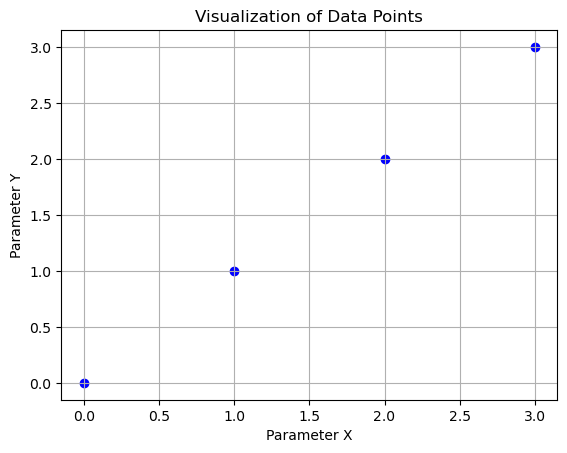

In [16]:
# Assuming x_vals and y_vals are parameter values
plt.scatter(param_x, param_y, c='blue', marker='o')
plt.title('Visualization of Data Points')
plt.xlabel('Parameter X')
plt.ylabel('Parameter Y')
plt.grid(True)
plt.show()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata

def plot_response_surface(x_vals, y_vals, results, param_x_name, param_y_name):
    # Prepare grid for interpolation
    grid_x, grid_y = np.mgrid[min(x_vals):max(x_vals):100j, min(y_vals):max(y_vals):100j]

    # Interpolate the results onto this grid
    grid_z = griddata((x_vals, y_vals), results, (grid_x, grid_y), method='nearest')

    # Plotting the response surface
    plt.figure(figsize=(10, 8))
    plt.contourf(grid_x, grid_y, grid_z, levels=100, cmap='viridis')
    plt.colorbar(label='Objective Function Value')
    plt.title(f'Response Surface for {param_x_name} and {param_y_name}')
    plt.xlabel(param_x_name)
    plt.ylabel(param_y_name)
    plt.show()


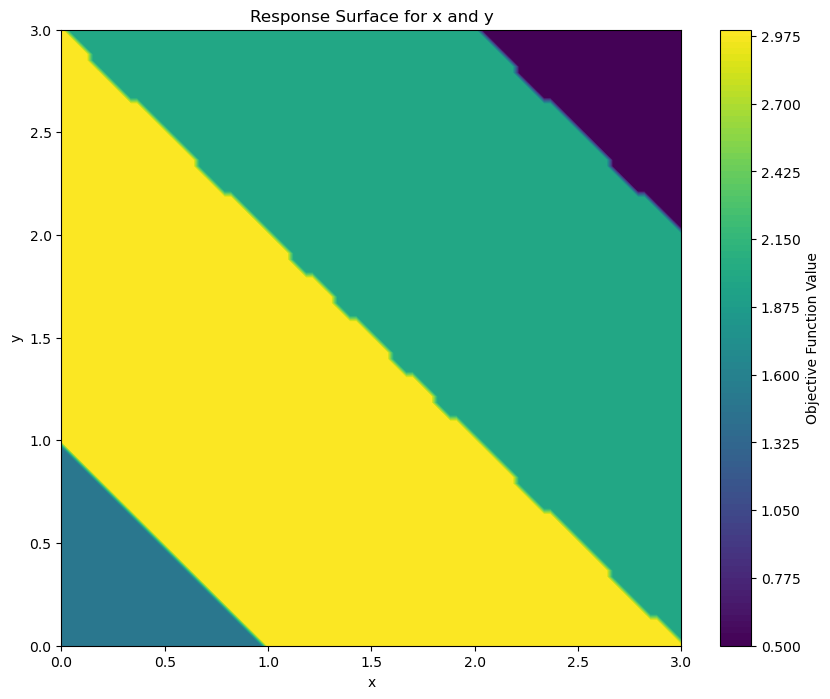

In [18]:
# Call the plotting function with these parameters
plot_response_surface(param_x, param_y, results, 'x', 'y')

## Next: Interactive update and plot

In [25]:
def plot_response_surface(optimizer):
    # Create a mesh grid of x and y values
    x = np.linspace(pbounds['x'][0], pbounds['x'][1], 100)
    y = np.linspace(pbounds['y'][0], pbounds['y'][1], 100)
    X, Y = np.meshgrid(x, y)
    # Flatten the grid to pass to the optimizer's model
    X_flat = X.ravel()
    Y_flat = Y.ravel()
    # Predict using the surrogate model
    mu, _ = optimizer._gp.predict(np.vstack((X_flat, Y_flat)).T, return_std=True)
    mu = mu.reshape(X.shape)
    
    # Plot
    plt.figure(figsize=(10, 8))
    contour = plt.contourf(X, Y, mu, 100)
    plt.colorbar(contour)
    plt.title('Response Surface')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

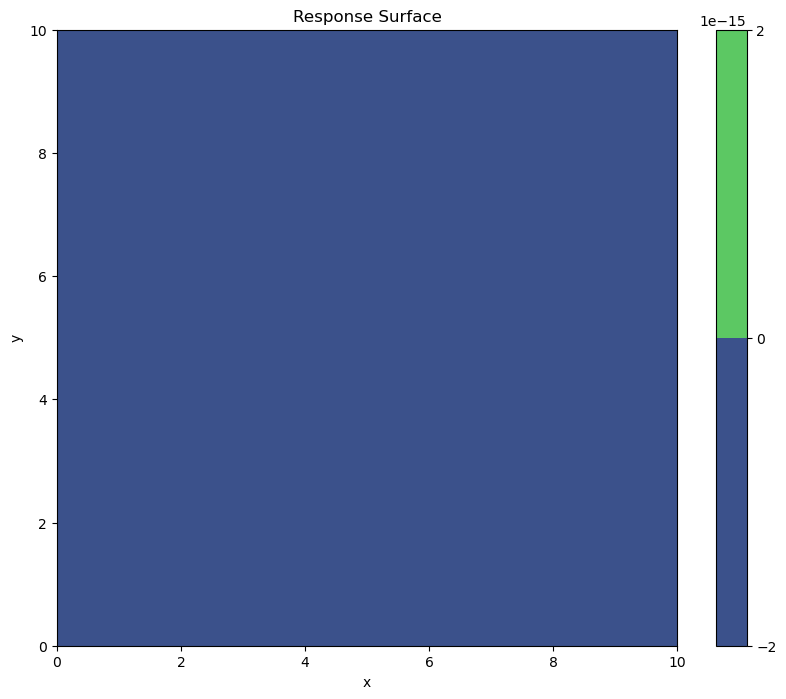

In [26]:
plot_response_surface(optimizer)

## Interactive Experiment Loop (suggest next experiment)

In [20]:
# Create a text input widget for entering the experiment results
result_input = widgets.FloatText(
    value=0.0,
    description='Result:',
    disabled=False
)

# Create a button to submit the result and update the optimization
submit_button = widgets.Button(description="Submit Result")

# Output widget to update the plots and text dynamically
output = widgets.Output()

In [21]:
def on_submit_clicked(b):
    # Update the optimizer with the new result
    optimizer.register(params=next_point, target=result_input.value)
    
    # Clear the previous output and display the updated plot
    with output:
        output.clear_output(wait=True)
        print(f"Updated with result: {result_input.value} at point: {next_point}")
        plot_response_surface(optimizer)
        display(result_input, submit_button)  # Display input and button again for next input

# Link the button to the update function
submit_button.on_click(on_submit_clicked)

In [22]:
# Utility function to initialize or reset the experiment suggestion
def start_experiment():
    global next_point  # Declare as global if it's being modified outside this scope
    next_point = optimizer.suggest(utility)
    with output:
        output.clear_output(wait=True)
        print(f"Suggested next point: {next_point}")
        display(result_input, submit_button)

# Display the initial setup
start_experiment()
display(output)

Output()